In [29]:
# Step 1: Imports
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests, re
from wordcloud import WordCloud
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab') # Download the punkt_tab resource

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [30]:
# Step 2: Scrape Wikipedia - Spain
url = "https://en.wikipedia.org/wiki/Spain"
response = requests.get(url)
soup = BeautifulSoup(response.content, "lxml")

# Step 3: Extract only paragraph text
text = " ".join([p.get_text() for p in soup.find_all("p")])
text = re.sub(r'\[\d+\]', '', text)  # remove citations like [1], [2]
text = re.sub(r'\s+', ' ', text)     # normalize whitespace


In [31]:
# Step 4: Sentence Tokenization
sentences = sent_tokenize(text)


In [32]:
# Step 5 & 6: Sentiment Analysis and DataFrame
def analyze_sentiment(sentence):
    return TextBlob(sentence).sentiment.polarity

sentiment_scores = [analyze_sentiment(sent) for sent in sentences]
sentiment_labels = ["positive" if s > 0 else "negative" if s < 0 else "neutral" for s in sentiment_scores]

df = pd.DataFrame({"Sentence": sentences, "Polarity": sentiment_scores, "Sentiment": sentiment_labels})


In [33]:
# Step 7–8: Word Tokenization & Stopword Removal
stop_words = set(stopwords.words("english"))
words = word_tokenize(text.lower())
filtered_words = [w for w in words if w.isalpha() and w not in stop_words]


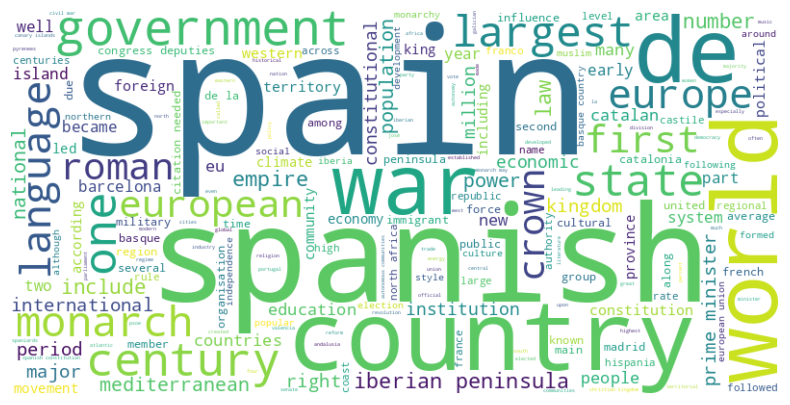

In [34]:
# Step 9: WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(filtered_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


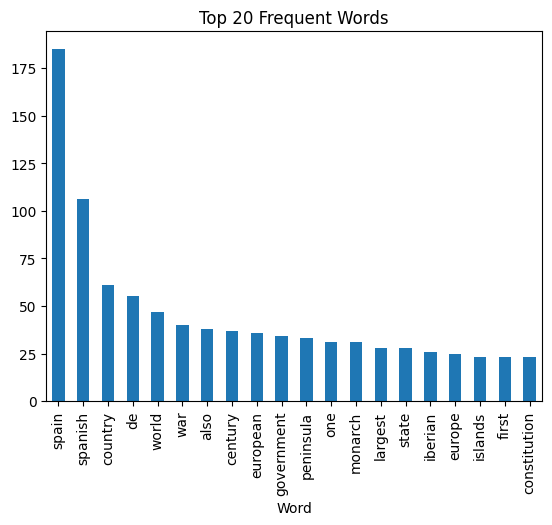

In [35]:
# Step 10: Frequency Counts
from collections import Counter
word_freq = Counter(filtered_words)
common_words = word_freq.most_common(20)
pd.DataFrame(common_words, columns=["Word", "Frequency"]).plot(kind="bar", x="Word", y="Frequency", legend=False)
plt.title("Top 20 Frequent Words")
plt.show()


In [36]:
# Step 11: TF-IDF Vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Sentence"])
y = df["Sentiment"]


In [37]:
# Step 12: Filter Only Positive & Negative
binary_df = df[df["Sentiment"] != "neutral"]
X = vectorizer.transform(binary_df["Sentence"])
y = binary_df["Sentiment"]


In [38]:
# Step 13: SMOTE Balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [39]:
# Step 14: ML Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": MultinomialNB(),
    "KNN": KNeighborsClassifier()
}

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:\n")
    print(classification_report(y_test, y_pred))



Logistic Regression:

              precision    recall  f1-score   support

    negative       0.93      0.92      0.93        62
    positive       0.91      0.92      0.91        52

    accuracy                           0.92       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.92      0.92      0.92       114


Decision Tree:

              precision    recall  f1-score   support

    negative       0.82      0.89      0.85        62
    positive       0.85      0.77      0.81        52

    accuracy                           0.83       114
   macro avg       0.84      0.83      0.83       114
weighted avg       0.83      0.83      0.83       114


Random Forest:

              precision    recall  f1-score   support

    negative       0.96      0.82      0.89        62
    positive       0.82      0.96      0.88        52

    accuracy                           0.89       114
   macro avg       0.89      0.89      0.89       114
weighted avg     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [40]:

# Step 5: Save .pkl Files
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("✅ Files saved: tfidf_vectorizer.pkl and sentiment_model.pkl")

✅ Files saved: tfidf_vectorizer.pkl and sentiment_model.pkl
